## InceptonResNetV2 fine-tuning-V4
从keras_fine_tunig_InceptonResNetV2-memory复制而来，为了重跑v2  

整体说明：
- 使用keras的InceptonResNetV2预训练模型进行fine-tuning，分别进行下面四种情况的fine-tuning
- 1、只训练自定义的输出层
- 2、冻结前698层，训练后面的层
- 3、冻结前618层，训练后面的层
- 4、冻结前499层，训练后面的层  
看哪种情况效果最好

修改内容：  
- 1、callbacks_list增加EarlyStopping，增加epochs，统一用epochs=20，利用EarlyStopping控制结束时机
- 2、改predict_on_model，test数据加内存，一次性完成

In [1]:
'''
数据目录结构：
data/
    train/    #原始数据，train.zip解压后生成
        dog.0.jpg
        cat.0.jpg
        ...
    train2/   #按标签分目录后的数据（连接文件）
        dog/
            dog.0.jpg
            dog.1.jpg
            ...
        cat/
            cat.0.jpg
            cat.1.jpg
            ...
    train3/   #去除异常图片后的训练数据（连接文件）
        dog/    #9983张图片
            dog.0.jpg
            dog.1.jpg
            ...
        cat/    #9961张图片
            cat.0.jpg
            cat.1.jpg
            ...
    validation/  #去除异常图片后的验证数据（连接文件）
        dog/   #2496张图片
            dog001.jpg
            dog002.jpg
            ...
        cat/   #2490张图片
            cat001.jpg
            cat002.jpg
            ...
    test/     
        test/  #测试集数据，12500张图片
            1.jpg
            2.jpg
            ...
'''
import cv2
import time
import pandas as pd
from tqdm import tqdm   #进度条
from PIL import Image
from helper import *

from keras.models import *
from keras.layers import *
from keras.applications import *
from keras.preprocessing.image import *
from keras.callbacks import *
from keras.optimizers import *
from keras.utils import *
from sklearn.utils import shuffle

# dimensions of our images.
img_width, img_height = 299, 299

train_data_dir = 'data/train2'
test_data_dir='data/test'

batch_size = 72   #19944/72=277  4986/72=69.25

epochs=20
VER=4
#模型权重文件
model_h5file_base="InceptonResNetV2-base-tuning-v{}.h5".format(VER)
model_h5file_tunig1="InceptonResNetV2-fine-tuning-1-v{}.h5".format(VER)
model_h5file_tunig2="InceptonResNetV2-fine-tuning-2-v{}.h5".format(VER)
model_h5file_tunig3="InceptonResNetV2-fine-tuning-3-v{}.h5".format(VER)
model_h5file_tunig4="InceptonResNetV2-fine-tuning-4-v{}.h5".format(VER)

#预测结果文件
pred_file_base="pred-InceptonResNetV2-base-tuning-v{}.csv".format(VER)
pred_file_tuning1="pred-InceptonResNetV2-fine-tuning-1-v{}.csv".format(VER)
pred_file_tuning2="pred-InceptonResNetV2-fine-tuning-2-v{}.csv".format(VER)
pred_file_tuning3="pred-InceptonResNetV2-fine-tuning-3-v{}.csv".format(VER)
pred_file_tuning4="pred-InceptonResNetV2-fine-tuning-4-v{}.csv".format(VER)

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
#构造InceptionResNetV2模型
start = time.clock()
x_input = Input((img_width, img_height, 3))
x_input = Lambda(inception_resnet_v2.preprocess_input)(x_input)

base_model = InceptionResNetV2(input_tensor=x_input, weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3), pooling = 'avg')
for layer in base_model.layers:
    layer.trainable = False
    
y = Dropout(0.25)(base_model.output)
y = Dense(1, activation='sigmoid')(y)
model = Model(inputs=base_model.input, outputs=y)

print("Load base model used time:", (time.clock() - start))


Load base model used time: 37.541256


In [3]:
adam = optimizers.Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

model.compile(optimizer=adam,
             loss='binary_crossentropy',
             metrics=['accuracy'])


In [5]:
# 输出模型结构图
#plot_model(model, to_file='model_InceptionResNetV2.png')

In [6]:
#生成训练、验证数据--全量读入内存
#X_train, Y_train=read_images_to_memory(train_data_dir, img_width, img_height, test=True)
X_train, Y_train=read_images_to_memory(train_data_dir, img_width, img_height)
X_train, Y_train=shuffle(X_train, Y_train)

#测试数据
X_test = load_test_data(12500, img_height, img_width, test_data_dir)

  0%|          | 0/12479 [00:00<?, ?it/s]

dog_nums=12479, cat_nums=12451
total images: 24930


100%|██████████| 12500/12500 [02:59<00:00, 69.62it/s]


In [7]:
model.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 299, 299, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 149, 149, 32) 864         lambda_1[0][0]                   
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 149, 149, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation

batch_normalization_176 (BatchN (None, 8, 8, 192)    576         conv2d_176[0][0]                 
__________________________________________________________________________________________________
batch_normalization_179 (BatchN (None, 8, 8, 256)    768         conv2d_179[0][0]                 
__________________________________________________________________________________________________
activation_176 (Activation)     (None, 8, 8, 192)    0           batch_normalization_176[0][0]    
__________________________________________________________________________________________________
activation_179 (Activation)     (None, 8, 8, 256)    0           batch_normalization_179[0][0]    
__________________________________________________________________________________________________
block8_4_mixed (Concatenate)    (None, 8, 8, 448)    0           activation_176[0][0]             
                                                                 activation_179[0][0]             
__________

In [8]:
#训练模型并保存在验证集上损失函数最小的权重
checkpoint = ModelCheckpoint(model_h5file_base, monitor='val_loss', verbose=1, save_best_only=True, mode='min',save_weights_only=True)
stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='min') #如连续3个epoch,loss都没有没有下降,则停止训练
callbacks_list = [stopping,checkpoint]

history=model.fit(X_train, Y_train, batch_size=128, epochs=epochs, validation_split=0.2, shuffle=True, callbacks=callbacks_list)

Train on 19944 samples, validate on 4986 samples
Epoch 1/20
19944/19944 [==============================] - 193s 10ms/step - loss: 0.5358 - acc: 0.7690 - val_loss: 0.3433 - val_acc: 0.8877

Epoch 00001: val_loss improved from inf to 0.34329, saving model to InceptonResNetV2-base-tuning-v4.h5
Epoch 2/20
19944/19944 [==============================] - 124s 6ms/step - loss: 0.3389 - acc: 0.9284 - val_loss: 0.2111 - val_acc: 0.9543

Epoch 00002: val_loss improved from 0.34329 to 0.21107, saving model to InceptonResNetV2-base-tuning-v4.h5
Epoch 3/20
19944/19944 [==============================] - 124s 6ms/step - loss: 0.2504 - acc: 0.9525 - val_loss: 0.1617 - val_acc: 0.9657

Epoch 00003: val_loss improved from 0.21107 to 0.16172, saving model to InceptonResNetV2-base-tuning-v4.h5
Epoch 4/20
19944/19944 [==============================] - 124s 6ms/step - loss: 0.2032 - acc: 0.9600 - val_loss: 0.1289 - val_acc: 0.9729

Epoch 00004: val_loss improved from 0.16172 to 0.12890, saving model to Incep

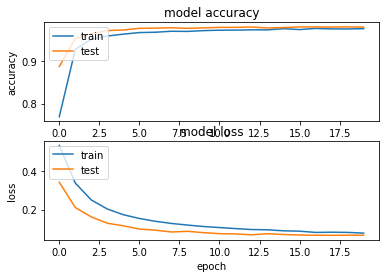

In [9]:
#可视化学习曲线
show_learning_curve(history)

In [10]:
#预测结果   
predict_on_model(X_test, model, model_h5file_base, pred_file_base)

12500/12500 [==============================] - 64s 5ms/step


  0%|          | 0/12500 [00:00<?, ?it/s]/home/ubuntu/dogs-and-cats/helper.py:150: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  df.set_value(i, 'label', y_test[i])
100%|██████████| 12500/12500 [00:00<00:00, 148383.54it/s]


## 冻结前698层，再训练
放开Inception-resnet-C第5个block之后的层，不含Inception-resnet-C_5  
698 block8_5_ac 

In [39]:
# 设置需要冻结的层数

for layer in base_model.layers:
    layer.trainable = True
    
lock_layers(model, locked_layer_nums=698)

0 input_1
1 lambda_1
2 conv2d_1
3 batch_normalization_1
4 activation_1
5 conv2d_2
6 batch_normalization_2
7 activation_2
8 conv2d_3
9 batch_normalization_3
10 activation_3
11 max_pooling2d_1
12 conv2d_4
13 batch_normalization_4
14 activation_4
15 conv2d_5
16 batch_normalization_5
17 activation_5
18 max_pooling2d_2
19 conv2d_9
20 batch_normalization_9
21 activation_9
22 conv2d_7
23 conv2d_10
24 batch_normalization_7
25 batch_normalization_10
26 activation_7
27 activation_10
28 average_pooling2d_1
29 conv2d_6
30 conv2d_8
31 conv2d_11
32 conv2d_12
33 batch_normalization_6
34 batch_normalization_8
35 batch_normalization_11
36 batch_normalization_12
37 activation_6
38 activation_8
39 activation_11
40 activation_12
41 mixed_5b
42 conv2d_16
43 batch_normalization_16
44 activation_16
45 conv2d_14
46 conv2d_17
47 batch_normalization_14
48 batch_normalization_17
49 activation_14
50 activation_17
51 conv2d_13
52 conv2d_15
53 conv2d_18
54 batch_normalization_13
55 batch_normalization_15
56 batch_n

In [40]:
model.load_weights(model_h5file_base)
adam = optimizers.Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(optimizer=adam,             
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [41]:
#训练模型并保存在验证集上损失函数最小的权重
checkpoint = ModelCheckpoint(model_h5file_tunig1, monitor='val_loss', verbose=1, save_best_only=True, mode='min',save_weights_only=True)
stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='min') #如连续3个epoch,loss都没有没有下降,则停止训练
callbacks_list = [stopping,checkpoint]

history=model.fit(X_train, Y_train, batch_size=128, epochs=epochs, validation_split=0.2, shuffle=True, callbacks=callbacks_list)

Train on 19944 samples, validate on 4986 samples
Epoch 1/20
19944/19944 [==============================] - 148s 7ms/step - loss: 0.0376 - acc: 0.9858 - val_loss: 0.0202 - val_acc: 0.9928

Epoch 00001: val_loss improved from inf to 0.02015, saving model to InceptonResNetV2-fine-tuning-1-v4.h5
Epoch 2/20
19944/19944 [==============================] - 130s 7ms/step - loss: 0.0110 - acc: 0.9966 - val_loss: 0.0155 - val_acc: 0.9954

Epoch 00002: val_loss improved from 0.02015 to 0.01554, saving model to InceptonResNetV2-fine-tuning-1-v4.h5
Epoch 3/20
19944/19944 [==============================] - 130s 7ms/step - loss: 0.0046 - acc: 0.9985 - val_loss: 0.0337 - val_acc: 0.9932

Epoch 00003: val_loss did not improve from 0.01554
Epoch 4/20
19944/19944 [==============================] - 130s 7ms/step - loss: 0.0019 - acc: 0.9994 - val_loss: 0.0237 - val_acc: 0.9940

Epoch 00004: val_loss did not improve from 0.01554
Epoch 5/20
19944/19944 [==============================] - 130s 7ms/step - loss:

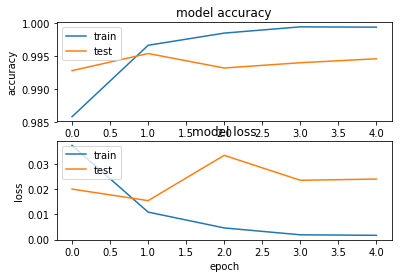

In [42]:
#可视化学习曲线
show_learning_curve(history)

In [43]:
#预测结果
predict_on_model(X_test, model, model_h5file_tunig1, pred_file_tuning1)

12500/12500 [==============================] - 72s 6ms/step


  0%|          | 0/12500 [00:00<?, ?it/s]/home/ubuntu/dogs-and-cats/helper.py:150: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  df.set_value(i, 'label', y_test[i])
100%|██████████| 12500/12500 [00:00<00:00, 152155.86it/s]


## 冻结前618层，再训练
放开Reduction-B之后的层，不含Reduction-B  
618 mixed_7a

In [44]:
# 设置需要冻结的层数

for layer in base_model.layers:
    layer.trainable = True
    
lock_layers(model, locked_layer_nums=618)

0 input_1
1 lambda_1
2 conv2d_1
3 batch_normalization_1
4 activation_1
5 conv2d_2
6 batch_normalization_2
7 activation_2
8 conv2d_3
9 batch_normalization_3
10 activation_3
11 max_pooling2d_1
12 conv2d_4
13 batch_normalization_4
14 activation_4
15 conv2d_5
16 batch_normalization_5
17 activation_5
18 max_pooling2d_2
19 conv2d_9
20 batch_normalization_9
21 activation_9
22 conv2d_7
23 conv2d_10
24 batch_normalization_7
25 batch_normalization_10
26 activation_7
27 activation_10
28 average_pooling2d_1
29 conv2d_6
30 conv2d_8
31 conv2d_11
32 conv2d_12
33 batch_normalization_6
34 batch_normalization_8
35 batch_normalization_11
36 batch_normalization_12
37 activation_6
38 activation_8
39 activation_11
40 activation_12
41 mixed_5b
42 conv2d_16
43 batch_normalization_16
44 activation_16
45 conv2d_14
46 conv2d_17
47 batch_normalization_14
48 batch_normalization_17
49 activation_14
50 activation_17
51 conv2d_13
52 conv2d_15
53 conv2d_18
54 batch_normalization_13
55 batch_normalization_15
56 batch_n

In [45]:
model.load_weights(model_h5file_tunig1)  #model_h5file_tunig1比base模型更好
adam = optimizers.Adam(lr=1e-5, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False) #学习率调小一点
model.compile(optimizer=adam,             
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [46]:
#训练模型并保存在验证集上损失函数最小的权重
checkpoint = ModelCheckpoint(model_h5file_tunig2, monitor='val_loss', verbose=1, save_best_only=True, mode='min',save_weights_only=True)
stopping = EarlyStopping(monitor='val_loss', patience=2, verbose=1, mode='min') #如连续2个epoch,loss都没有没有下降,则停止训练
callbacks_list = [stopping,checkpoint]

history=model.fit(X_train, Y_train, batch_size=128, epochs=epochs, validation_split=0.2, shuffle=True, callbacks=callbacks_list)

Train on 19944 samples, validate on 4986 samples
Epoch 1/20
19944/19944 [==============================] - 152s 8ms/step - loss: 0.0031 - acc: 0.9991 - val_loss: 0.0155 - val_acc: 0.9950

Epoch 00001: val_loss improved from inf to 0.01554, saving model to InceptonResNetV2-fine-tuning-2-v4.h5
Epoch 2/20
19944/19944 [==============================] - 137s 7ms/step - loss: 0.0011 - acc: 0.9999 - val_loss: 0.0152 - val_acc: 0.9956

Epoch 00002: val_loss improved from 0.01554 to 0.01521, saving model to InceptonResNetV2-fine-tuning-2-v4.h5
Epoch 3/20
19944/19944 [==============================] - 137s 7ms/step - loss: 6.6223e-04 - acc: 0.9998 - val_loss: 0.0161 - val_acc: 0.9952

Epoch 00003: val_loss did not improve from 0.01521
Epoch 4/20
19944/19944 [==============================] - 137s 7ms/step - loss: 4.6021e-04 - acc: 0.9999 - val_loss: 0.0176 - val_acc: 0.9950

Epoch 00004: val_loss did not improve from 0.01521
Epoch 00004: early stopping


In [47]:
#预测结果
predict_on_model(X_test, model, model_h5file_tunig2, pred_file_tuning2)

12500/12500 [==============================] - 65s 5ms/step


  0%|          | 0/12500 [00:00<?, ?it/s]/home/ubuntu/dogs-and-cats/helper.py:150: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  df.set_value(i, 'label', y_test[i])
100%|██████████| 12500/12500 [00:00<00:00, 152438.11it/s]


## 冻结前499层，再训练
放开Inception-resnet-B 第17个block之后的层，不含包Inception-resnet-B_17  
499 block17_14_ac

In [48]:
# 设置需要冻结的层数
for layer in base_model.layers:
    layer.trainable = True
    
lock_layers(model, locked_layer_nums=499)

0 input_1
1 lambda_1
2 conv2d_1
3 batch_normalization_1
4 activation_1
5 conv2d_2
6 batch_normalization_2
7 activation_2
8 conv2d_3
9 batch_normalization_3
10 activation_3
11 max_pooling2d_1
12 conv2d_4
13 batch_normalization_4
14 activation_4
15 conv2d_5
16 batch_normalization_5
17 activation_5
18 max_pooling2d_2
19 conv2d_9
20 batch_normalization_9
21 activation_9
22 conv2d_7
23 conv2d_10
24 batch_normalization_7
25 batch_normalization_10
26 activation_7
27 activation_10
28 average_pooling2d_1
29 conv2d_6
30 conv2d_8
31 conv2d_11
32 conv2d_12
33 batch_normalization_6
34 batch_normalization_8
35 batch_normalization_11
36 batch_normalization_12
37 activation_6
38 activation_8
39 activation_11
40 activation_12
41 mixed_5b
42 conv2d_16
43 batch_normalization_16
44 activation_16
45 conv2d_14
46 conv2d_17
47 batch_normalization_14
48 batch_normalization_17
49 activation_14
50 activation_17
51 conv2d_13
52 conv2d_15
53 conv2d_18
54 batch_normalization_13
55 batch_normalization_15
56 batch_n

In [50]:
model.load_weights(model_h5file_base) 
adam = optimizers.Adam(lr=1e-5, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(optimizer=adam,             
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [51]:
#训练模型并保存在验证集上损失函数最小的权重
checkpoint = ModelCheckpoint(model_h5file_tunig3, monitor='val_loss', verbose=1, save_best_only=True, mode='min',save_weights_only=True)
stopping = EarlyStopping(monitor='val_loss', patience=2, verbose=1, mode='min') #如连续2个epoch,loss都没有没有下降,则停止训练
callbacks_list = [stopping,checkpoint]

history=model.fit(X_train, Y_train, batch_size=128, epochs=epochs, validation_split=0.2, shuffle=True, callbacks=callbacks_list)


Train on 19944 samples, validate on 4986 samples
Epoch 1/20
19944/19944 [==============================] - 183s 9ms/step - loss: 0.0416 - acc: 0.9866 - val_loss: 0.0169 - val_acc: 0.9952

Epoch 00001: val_loss improved from inf to 0.01694, saving model to InceptonResNetV2-fine-tuning-3-v4.h5
Epoch 2/20
19944/19944 [==============================] - 163s 8ms/step - loss: 0.0150 - acc: 0.9949 - val_loss: 0.0148 - val_acc: 0.9964

Epoch 00002: val_loss improved from 0.01694 to 0.01478, saving model to InceptonResNetV2-fine-tuning-3-v4.h5
Epoch 3/20
19944/19944 [==============================] - 163s 8ms/step - loss: 0.0079 - acc: 0.9980 - val_loss: 0.0143 - val_acc: 0.9962

Epoch 00003: val_loss improved from 0.01478 to 0.01434, saving model to InceptonResNetV2-fine-tuning-3-v4.h5
Epoch 4/20
19944/19944 [==============================] - 163s 8ms/step - loss: 0.0038 - acc: 0.9992 - val_loss: 0.0151 - val_acc: 0.9962

Epoch 00004: val_loss did not improve from 0.01434
Epoch 5/20
19944/1994

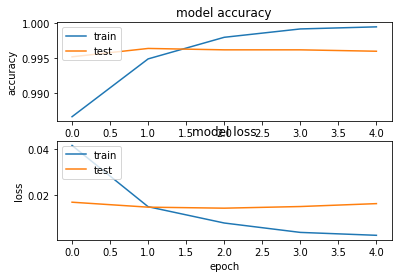

In [52]:
#可视化学习曲线
show_learning_curve(history)

In [53]:
#预测结果
predict_on_model(X_test, model, model_h5file_tunig3, pred_file_tuning3)

12500/12500 [==============================] - 65s 5ms/step


  0%|          | 0/12500 [00:00<?, ?it/s]/home/ubuntu/dogs-and-cats/helper.py:150: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  df.set_value(i, 'label', y_test[i])
100%|██████████| 12500/12500 [00:00<00:00, 148345.33it/s]
